# Measure systematic uncertainties in resolution with Kr data

<i>
This notebook takes a kDST file and a correction file,
applies all corrections (including time) and measures
the variation of the resolution when the corrections
are off by a certain value
</i>

### Notebook configuration

In [1]:
run_number          = 4734
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
dst_filename        = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"

XY_pitch            = 5.0

Zrange              =     0, 560
XYrange             =  -200, 200
Rrange              =     0, max(XYrange)
Phirange            = -3.14, 3.14

Erange              =  33.5, 49.5

XYnbins             =  50
Znbins              =  10
Rnbins              =  10
Enbins              = 200

R_fiducial          =  80
Z_fiducial          = 100

# Plotting style
default_cmap        = "jet"
figure_size         = 16, 12
font_size           = 20
global_linewidth    = 4
subfit_linewidth    = 4
global_linecolor    = "r"
subfit_linecolor    = "m g b y".split()
subfit_linecolor    = "b m slategrey c b y".split()

### Imports

In [3]:
import os
import time
import collections
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt
import scipy.optimize    as opt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.corrections    as corrf
import invisible_cities.reco.dst_functions  as dstf

from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import hist2d
from invisible_cities.icaro. hst_functions import pdf
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import gausstext
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import labels
from invisible_cities.icaro. hst_functions import measurement_string

Running on  Thu Mar 29 13:05:26 2018


### Initialization

In [4]:
%matplotlib inline

plt.rcParams["figure.figsize"         ] = figure_size
plt.rcParams[  "font.size"            ] =   font_size
plt.rcParams["figure.max_open_warning"] = 1000

In [5]:
Zbins     = np.linspace(*  Zrange   ,   Znbins + 1)
Rbins     = np.linspace(*  Rrange   ,   Rnbins + 1)
Ebins     = np.linspace(*  Erange   ,   Enbins + 1)
XYbins    = np.linspace(* XYrange   ,  XYnbins + 1)

Zcenters  = shift_to_bin_centers(Zbins)
Rcenters  = shift_to_bin_centers(Rbins)

dst_filename        = os.path.expandvars(       dst_filename)
correction_filename = os.path.expandvars(correction_filename)

### Read data

In [6]:
dst = dstf.load_dst(dst_filename, "DST", "Events")
dst = dst[dst.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(dst))
dst.head()

906981


,index,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,0,6,1.507368e+09,0,1,150.0,0.918589,5.302018,260975.0,10.7625,...,654500.0,32,393.525,393.525,110.109160,76.577461,134.119852,0.607678,13.281222,12.380607
1,1,8,1.507368e+09,0,1,125.0,1.663614,7.505072,311675.0,10.4875,...,654500.0,31,342.825,342.825,-84.927306,42.502615,94.969045,2.677578,12.633615,15.235298
2,3,12,1.507368e+09,0,1,225.0,2.741303,17.944131,209450.0,10.8625,...,653500.0,29,444.050,444.050,-34.455078,145.627975,149.648453,1.803121,12.388186,25.229376
3,5,17,1.507368e+09,0,1,200.0,1.953479,9.259772,240275.0,11.4375,...,654500.0,29,414.225,414.225,81.499882,-74.629563,110.507025,-0.741423,25.768544,12.567276
4,6,18,1.507368e+09,0,1,300.0,5.919568,32.076883,269525.0,10.6625,...,653500.0,34,383.975,383.975,15.658394,-195.197920,195.824955,-1.490750,20.252646,26.597081


In [8]:
LT_correction  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                   group = "XYcorrections",
                                                   node  = "Lifetime")

GEO_correction = dstf.load_xy_corrections(correction_filename,
                                          group         =  "XYcorrections",
                                          node          = f"GeometryE_{XY_pitch:.1f}mm",
                                          norm_strategy =  "const",
                                          norm_opts     = {"value": 41.5})

In [9]:
evt = dst.event.values
T   =(dst.time .values -
      dst.time.values.min()) / 60
S2n = dst.nS2  .values

S1e = dst.S1e.values
S1w = dst.S1w.values
S1h = dst.S1h.values
S1t = dst.S1t.values

S2e = dst.S2e.values
S2w = dst.S2w.values
S2h = dst.S2h.values
S2t = dst.S2t.values
S2q = dst.S2q.values

X   = dst.X    .values
Y   = dst.Y    .values
Z   = dst.DT   .values
R   = dst.R    .values
Phi = dst.Phi  .values
Nsi = dst.Nsipm.values

E  = S2e * LT_correction(Z, X, Y).value * GEO_correction(X, Y).value

In [10]:
t, e, eu = fitf.profileX(T, E, 100)
T_correction = corrf.Correction((t,), e, eu, norm_strategy="max")
E = E * T_correction(T).value

##### Input maps

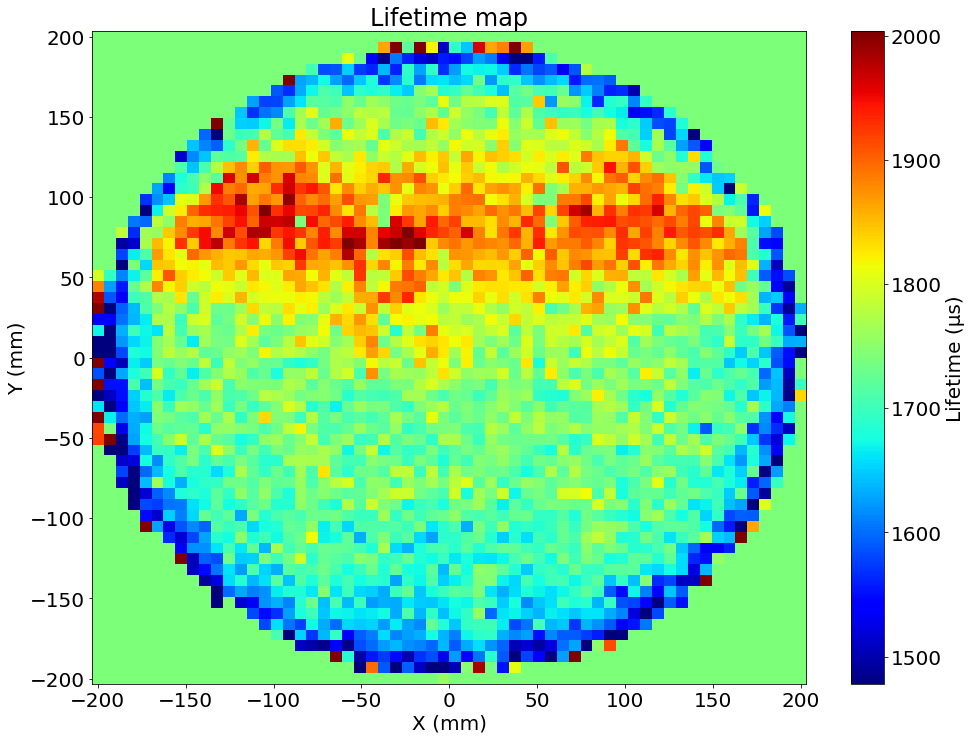

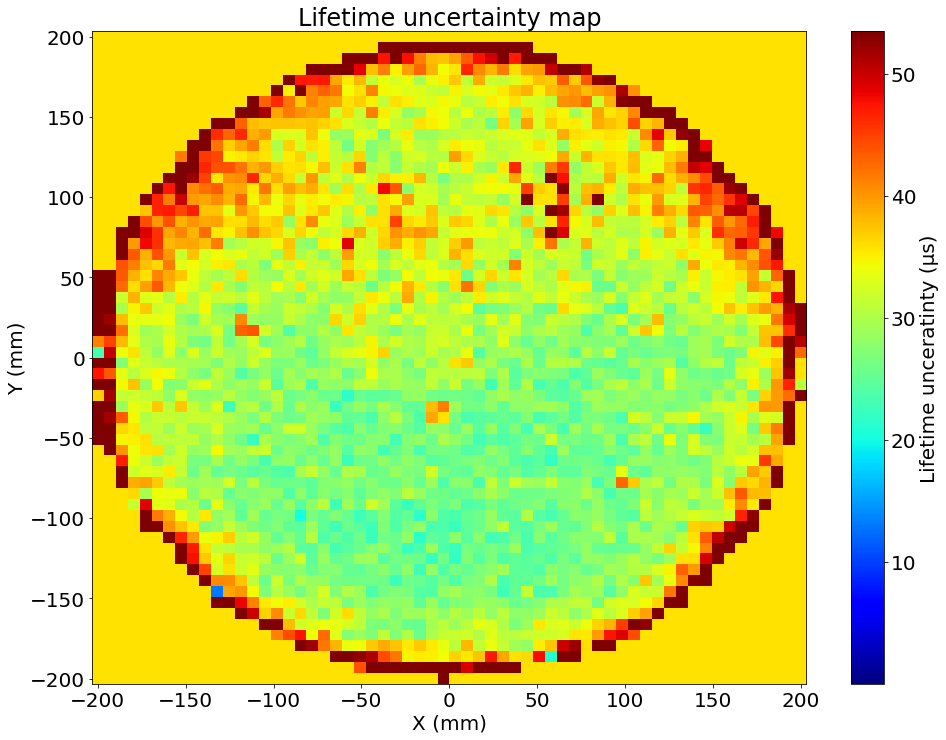

In [11]:
LTmap = dstf.load_dst(correction_filename,
                      group = "XYcorrections",
                      node  = "Lifetime")

x   = np.unique(LTmap.x.values)
y   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(x.size, y.size)
LTu = LTmap.uncertainty.values.reshape(x.size, y.size)

*_, cb = display_matrix(x, y, LT,
                        vmin = np.mean(LT) - 2.5 * np.std(LT),
                        vmax = np.mean(LT) + 2.5 * np.std(LT),
                        cmap = default_cmap)
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime map")

*_, cb = display_matrix(x, y, LTu,
                        vmin = 1e-3,
                        vmax = np.mean(LTu) + np.std(LTu),
                        cmap = default_cmap)

cb.set_label("Lifetime unceratinty (µs)")
labels("X (mm)", "Y (mm)", "Lifetime uncertainty map")

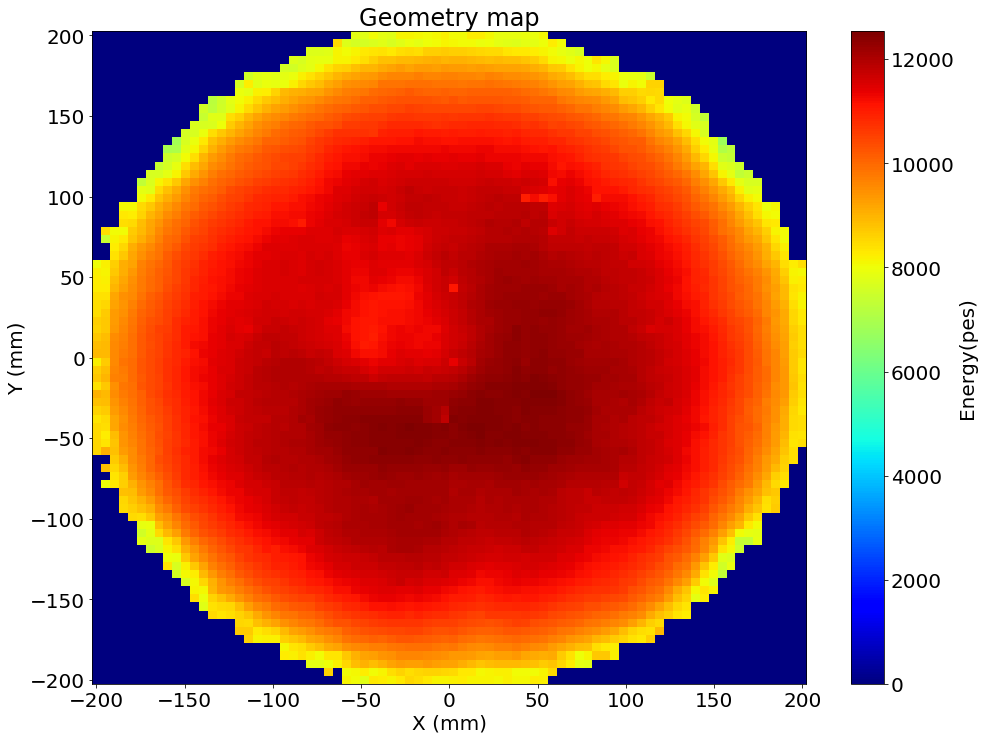

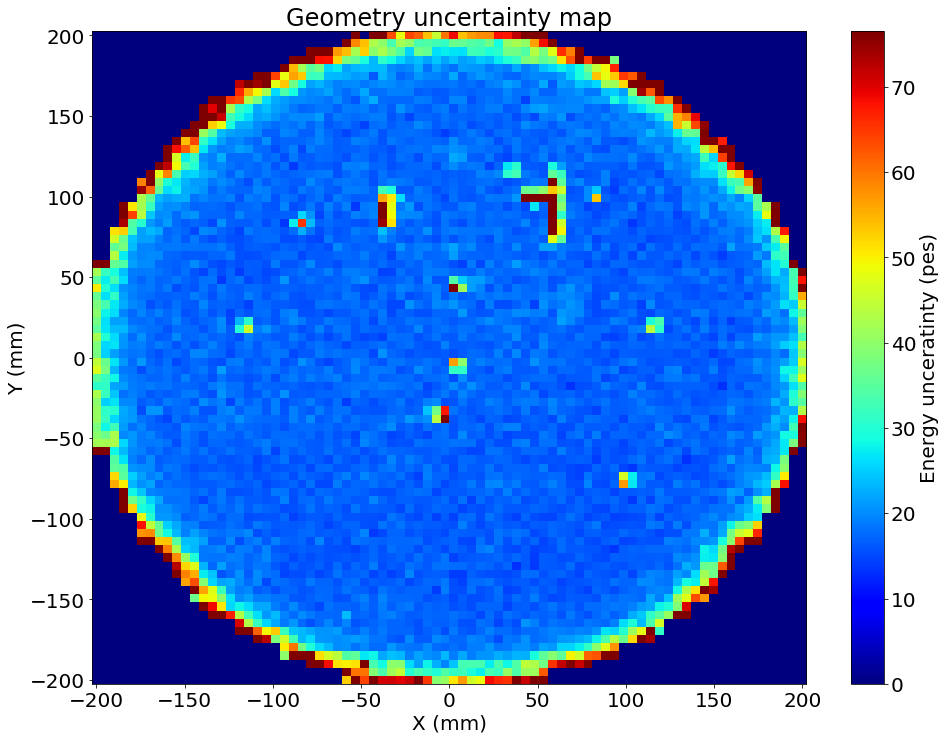

In [12]:
GEOmap = dstf.load_dst(correction_filename,
                       group = "XYcorrections",
                       node  = f"GeometryE_{XY_pitch:.1f}mm")

x  = np.unique(GEOmap.x.values)
y  = np.unique(GEOmap.y.values)
f  = GEOmap.factor     .values.reshape(x.size, y.size)
fu = GEOmap.uncertainty.values.reshape(x.size, y.size)

*_, cb = display_matrix(x, y, f,
                        cmap = default_cmap)
cb.set_label("Energy(pes)")
labels("X (mm)", "Y (mm)", "Geometry map")

*_, cb = display_matrix(x, y, fu,
                        vmax = np.mean(fu) + 3 * np.std(fu),
                        cmap = default_cmap)
cb.set_label("Energy unceratinty (pes)")
labels("X (mm)", "Y (mm)", "Geometry uncertainty map")


##### Energy resolution

In [13]:
xy_data       = collections.namedtuple(      "xy_data", "x y xu yu"       )
reso_fit_data = collections.namedtuple("reso_fit_data", "xy residuals f R")

def measure_resolution(E, bkg=fitf.gauss):
    y, x  = np.histogram(E, Ebins)
    x     = shift_to_bin_centers(x)
    xu    = np.diff(x)[0] * 0.5
    yu    = poisson_sigma(y)

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + bkg(x, *args[3:])
    Npeak = np.size(E) * np.diff(Ebins)[0]
    Epeak = np.average( x            , weights=y)
    Speak = np.average((x - Epeak)**2, weights=y)**0.5

    bkg_seed = (Npeak*2, Epeak, Speak*50) if bkg is fitf.gauss else (1, 1, 1)
    sig_seed  = Npeak, Epeak, Speak

    seed = (*sig_seed, *bkg_seed)
    fit_range = (Epeak - 4 * Speak,
                 Epeak + 4 * Speak)
    f    = fitf.fit(fun, x, y, seed,
                    fit_range = fit_range,
                    sigma     = yu,
                    maxfev    = 10000)

    assert not np.any(np.isclose(f.values, seed)), f.values

    R   = resolution(f.values, f.errors, 41.5)
    sel = coref.in_range(x, *fit_range)
    ry  = (f.fn(x) - y) / yu
    return reso_fit_data(xy_data(x, y, xu, yu),
                         xy_data(x[sel], ry[sel], xu, yu[sel]),
                         f, R)

def plot(data, signal=fitf.gauss, bkg=fitf.gauss):
    print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
    print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
    print("Chi2                  :", data.f.chi2)

    x = data.xy.x
    plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
    plt.plot        (x, data.f.fn   (x)               , lw=global_linewidth, color=global_linecolor   )
    plt.plot        (x, signal(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
    plt.fill_between(x, signal(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
    plt.plot        (x, bkg   (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
    plt.fill_between(x, bkg   (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
    plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
             max(data.xy.y) / 1.5,
             gausstext(data.f.values, data.f.errors, 41.5))
    plt.ylim(0)
    labels("E (keV)", "Entries")

##### Reference value

Resolution at 41.5 keV: 4.7679 +- 0.0061
Resolution at 2458 keV: 0.61952 +- 0.00080
Chi2                  : 12.293820344


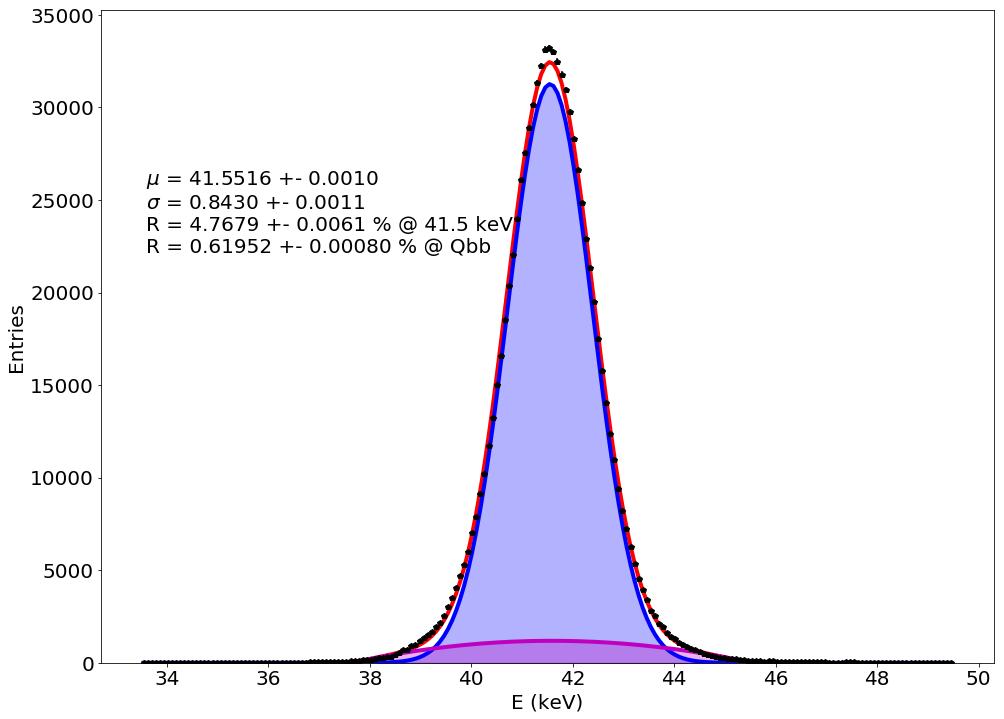

In [15]:
bkg  = fitf.polynom
data = measure_resolution(E, bkg=bkg)

plot(data, bkg=bkg)

##### Lifetime systematics

In [16]:
nsigmas_lt = 20
sigmas_lt  = np.linspace(-5, 5, nsigmas_lt)
E0         = S2e * GEO_correction(X, Y).value * T_correction(T).value
LTdst      = dstf.load_dst(correction_filename,
                           group = "XYcorrections",
                           node  = "Lifetime")
Xs         = np.unique(LTdst.x.values)
Ys         = np.unique(LTdst.y.values)
LTs        = LTdst.factor     .values.reshape(Xs.size, Ys.size)
LTus       = LTdst.uncertainty.values.reshape(Xs.size, Ys.size)

globalR_lt  = np.zeros ( nsigmas_lt)
globalRu_lt = np.zeros ( nsigmas_lt)
z_lt        = np.repeat([Zcenters] , nsigmas_lt, axis=0)
zR_lt       = np.zeros ((nsigmas_lt, Znbins))
zRu_lt      = np.zeros ((nsigmas_lt, Znbins))
zok_lt      = np.zeros ((nsigmas_lt, Znbins), dtype=bool)
r_lt        = np.repeat([Rcenters] , nsigmas_lt, axis=0)
rR_lt       = np.zeros ((nsigmas_lt, Rnbins))
rRu_lt      = np.zeros ((nsigmas_lt, Rnbins))
rok_lt      = np.zeros ((nsigmas_lt, Rnbins), dtype=bool)
datas_lt    = []
for i, nsig in enumerate(sigmas_lt):
    lt = corrf.Correction((Xs, Ys), LTs + nsig * LTus, LTus)
    LT_correction = lambda z, x, y: corrf.LifetimeCorrection(*lt(x, y))(z)
    e = E0 * LT_correction(Z, X, Y).value

    bkg  = fitf.polynom
    data = measure_resolution(e, bkg=bkg)
    """
    plot(data, bkg=bkg)
    break
    """
    globalR_lt[i], globalRu_lt[i] = data.R[0]
    datas_lt.append(data)

    for j in range(Znbins):
        sel  = coref.in_range(Z, *Zbins[j:j+2])
        try:
            data = measure_resolution(e[sel], bkg=bkg)
            zR_lt [i, j], zRu_lt[i, j] = data.R[0]
            zok_lt[i, j] = True
        except Exception as e:
            pass

    for j in range(Rnbins):
        sel  = coref.in_range(R, *Rbins[j:j+2])
        try:
            data = measure_resolution(e[sel], bkg=bkg)
            rR_lt [i, j], rRu_lt[i, j] = data.R[0]
            rok_lt[i, j] = True
        except:
            pass

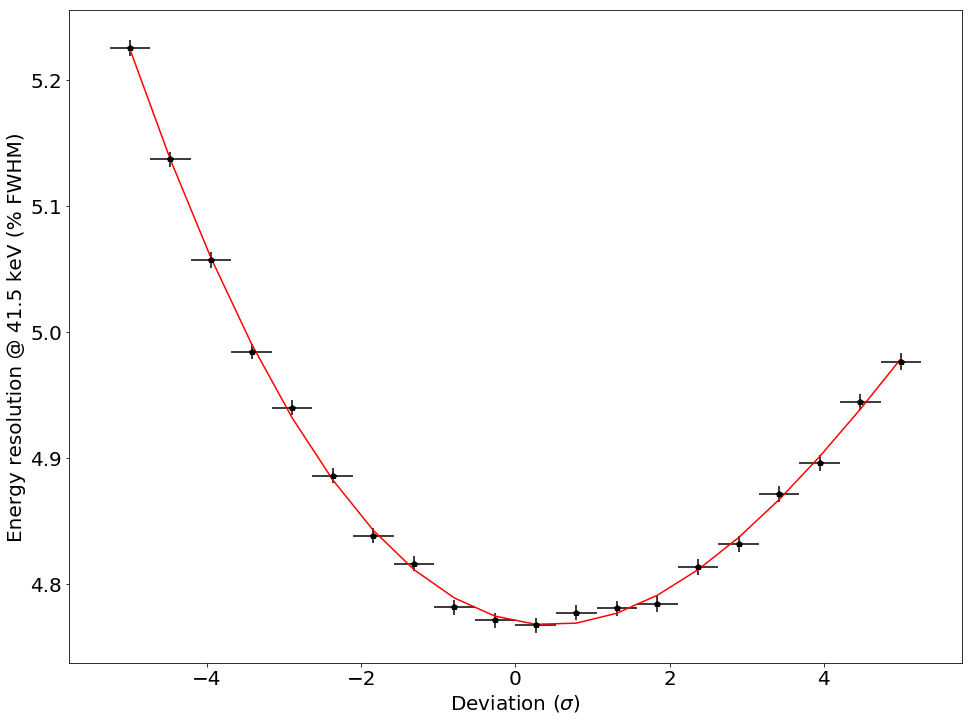

In [26]:
plt.errorbar(sigmas_lt, globalR_lt, globalRu_lt, np.diff(sigmas_lt)[0]/2, "pk")
f = fitf.fit(fitf.polynom, sigmas_lt, globalR_lt, tuple(1 for i in range(5)), sigma=globalRu_lt)
plt.plot(sigmas_lt, f.fn(sigmas_lt), "r-")
labels("Deviation ($\sigma$)", "Energy resolution @ 41.5 keV (% FWHM)")

In [41]:
min_data = opt.minimize(f.fn, 0)
min_x    = min_data.x[0]
min_y    = min_data.fun
print(f.fn(min_x - 2) - min_y, f.fn(min_x + 2) - min_y)
min_data

0.0875442584793 0.0875440808772


      fun: 7.249036820900985
 hess_inv: array([[ 22.84288597]])
      jac: array([ 0.])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([ 0.01673487])

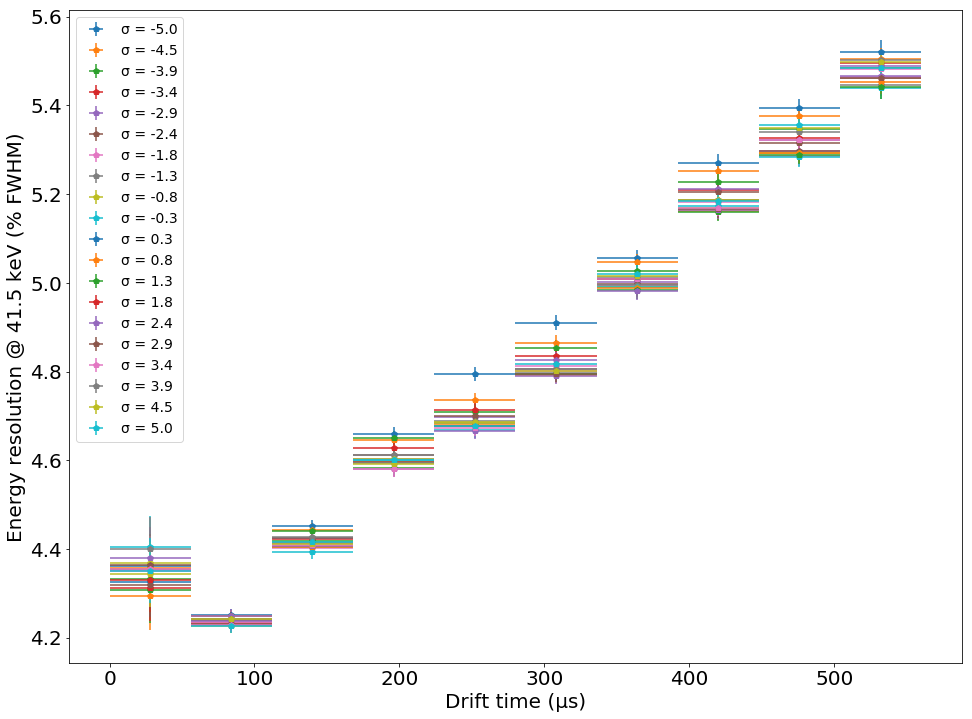

In [31]:
for i in range(nsigmas_lt):
    ok = zok_lt[i]
    plt.errorbar(z_lt[i][ok], zR_lt[i][ok], zRu_lt[i][ok], np.diff(Zcenters)[0]/2,
                 fmt = "p", label = f"σ = {sigmas_lt[i]:.1f}")

plt.legend(fontsize=14)
labels("Drift time (µs)", "Energy resolution @ 41.5 keV (% FWHM)")

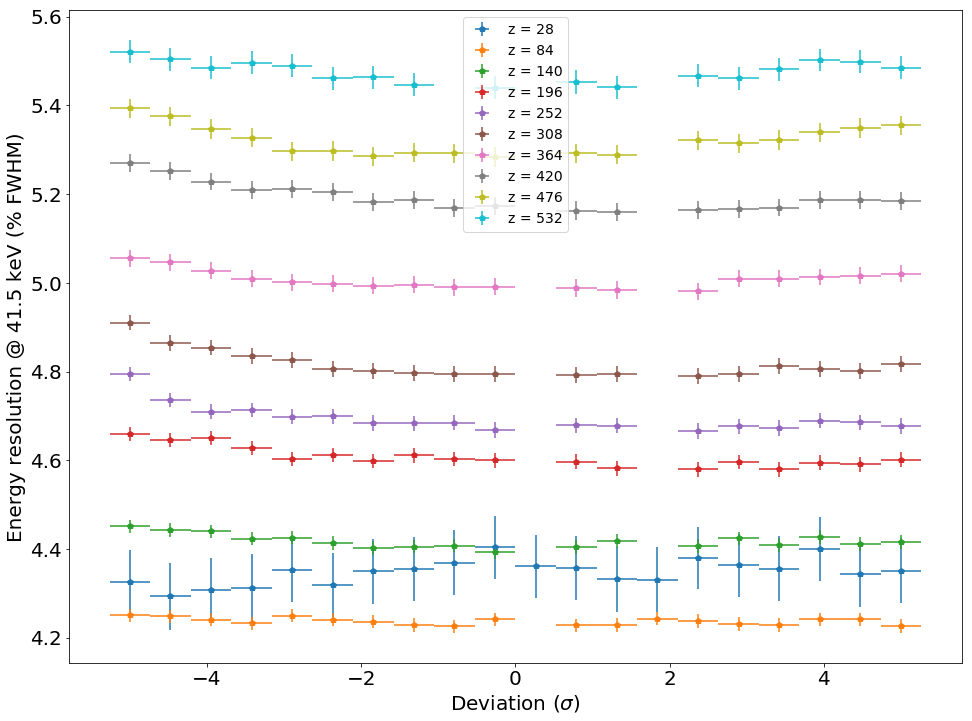

In [32]:
for i in range(Znbins):
    ok = zok_lt[:, i]
    plt.errorbar(sigmas_lt[ok], zR_lt[:, i][ok], zRu_lt[:, i][ok], np.diff(sigmas_lt)[0]/2,
                 fmt = "p", label = f"z = {Zcenters[i]:.0f}")

plt.legend(fontsize=14)
labels("Deviation ($\sigma$)", "Energy resolution @ 41.5 keV (% FWHM)")

IndexError: tuple index out of range

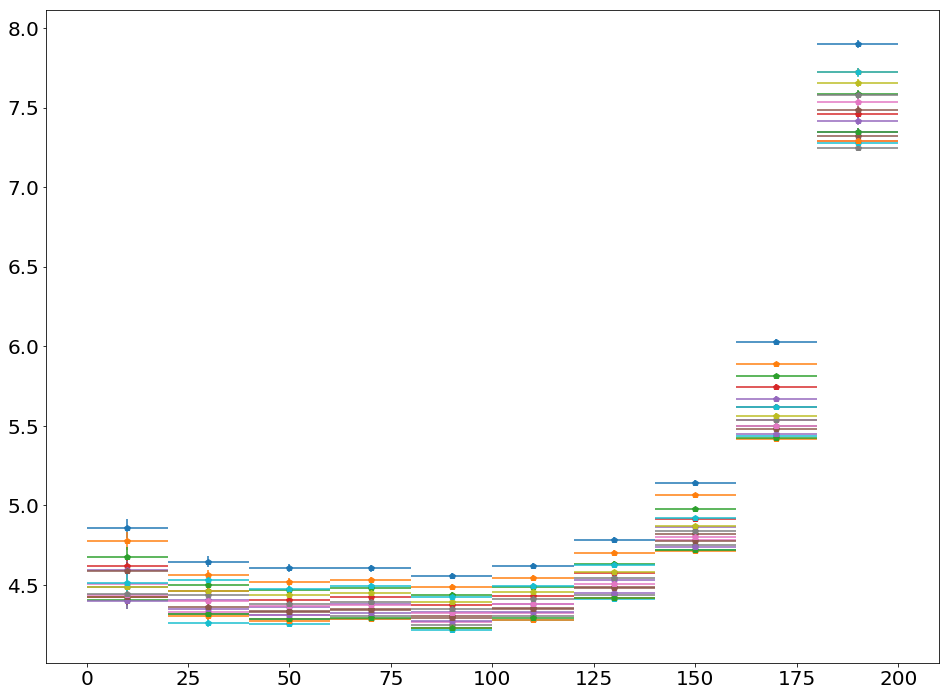

In [35]:
for i in range(nsigmas_lt):
    ok = rok_lt[i]
    plt.errorbar(r_lt[i][ok], rR_lt[i][ok], rRu_lt[i][ok], np.diff(Rcenters)[0]/2,
                 fmt = "p", label = f"σ = {sigmas_lt[i]:.1f}")

plt.legend(fontsize=14)
labels("Drift time (µs)", "Energy resolution @ 41.5 keV (% FWHM)")

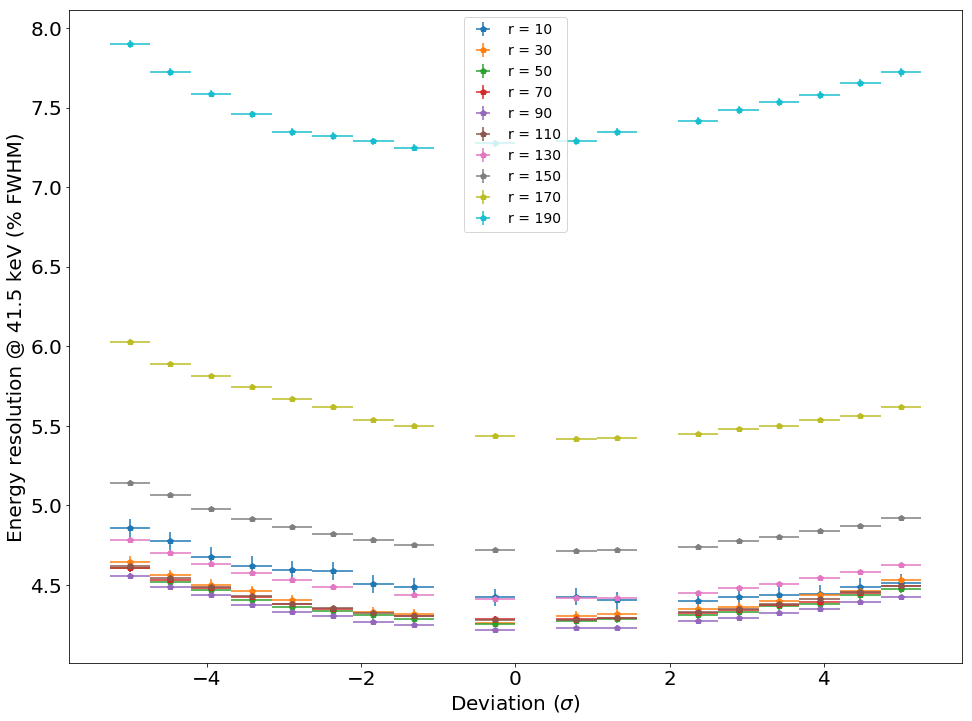

In [37]:
mins = np.zeros(Rnbins)
for i in range(Rnbins):
    ok = rok_lt[:, i]
    plt.errorbar(sigmas_lt[ok], rR_lt[:, i][ok], rRu_lt[:, i][ok], np.diff(sigmas_lt)[0]/2,
                 fmt = "p", label = f"r = {Rcenters[i]:.0f}")

    f = fitf.fit(fitf.polynom, sigmas_lt[ok], rR_lt[:, i][ok], (1, 1, 1))
    min_data = opt.minimize(f.fn, 0)
    min_x    = min_data.x[0]
    mins[i] = min_x

plt.legend(fontsize=14)
labels("Deviation ($\sigma$)", "Energy resolution @ 41.5 keV (% FWHM)")

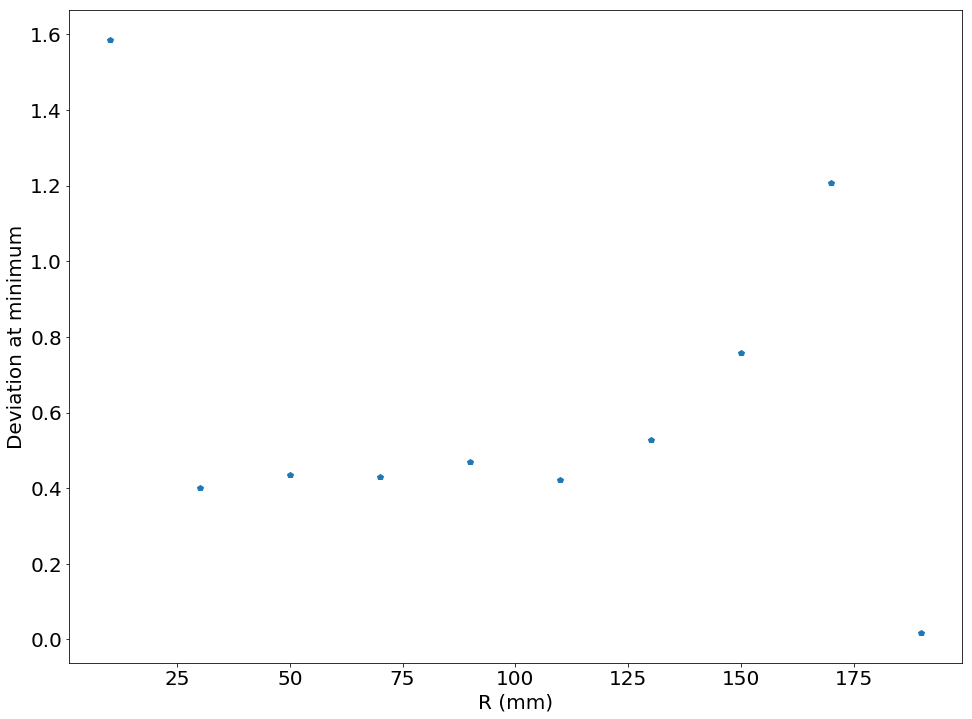

In [40]:
plt.errorbar(Rcenters, mins, fmt="p")
labels("R (mm)", "Deviation at minimum")

In [43]:
nsigmas_geo = 50
sigmas_geo  = np.linspace(-10, 10, nsigmas_geo) 
E0          = S2e * LT_correction(Z, X, Y).value * T_correction(T).value
GEOdst      = dstf.load_dst(correction_filename,
                            group = "XYcorrections",
                            node  = f"Geometry_{XY_pitch:.1f}mm")
Xs          = np.unique(GEOdst.x.values)
Ys          = np.unique(GEOdst.y.values)
Fs          = GEOdst.factor     .values.reshape(Xs.size, Ys.size)
Fus         = GEOdst.uncertainty.values.reshape(Xs.size, Ys.size)


globalR_geo  = np.zeros ( nsigmas_geo)
globalRu_geo = np.zeros ( nsigmas_geo)
z_geo        = np.repeat([Zcenters]  , nsigmas_geo, axis=0)
zR_geo       = np.zeros ((nsigmas_geo, Znbins))
zRu_geo      = np.zeros ((nsigmas_geo, Znbins))
zok_geo      = np.zeros ((nsigmas_geo, Znbins), dtype=bool)
r_geo        = np.repeat([Rcenters]  , nsigmas_geo, axis=0)
rR_geo       = np.zeros ((nsigmas_geo, Rnbins))
rRu_geo      = np.zeros ((nsigmas_geo, Rnbins))
rok_geo      = np.zeros ((nsigmas_geo, Rnbins), dtype=bool)

datas_geo = []
for i, nsig in enumerate(sigmas_geo):
    GEO_correction = corrf.Correction((Xs, Ys), Fs + nsig * Fus, Fus,
                                      norm_strategy="const", norm_opts={"value": 41.5})
    e = E0 * GEO_correction(X, Y).value

    bkg  = fitf.polynom
    data = measure_resolution(e, bkg=bkg)
    datas_geo.append(data)
    """
    plot(data, bkg=bkg)
    break
    """
    globalR_geo[i], globalRu_geo[i] = data.R[0]
    
    for j in range(Znbins):
        sel  = coref.in_range(Z, *Zbins[j:j+2])
        try:
            data = measure_resolution(e[sel], bkg=bkg)
            zR_geo [i, j], zRu_geo[i, j] = data.R[0]
            zok_geo[i, j] = True
        except:
            pass

    for j in range(Rnbins):
        sel  = coref.in_range(R, *Rbins[j:j+2])
        try:
            data = measure_resolution(e[sel], bkg=bkg)
            rR_geo [i, j], rRu_geo[i, j] = data.R[0]
            rok_geo[i, j] = True
        except:
            pass

NoSuchNodeError: group ``/XYcorrections`` does not have a child named ``Geometry_5.0mm``

In [ ]:
plt.errorbar(sigmas_geo, globalR_geo, globalRu_geo, np.diff(sigmas_geo)[0]/2, "pk")
labels("Deviation ($\sigma$)", "Energy resolution @ 41.5 keV (% FWHM)")

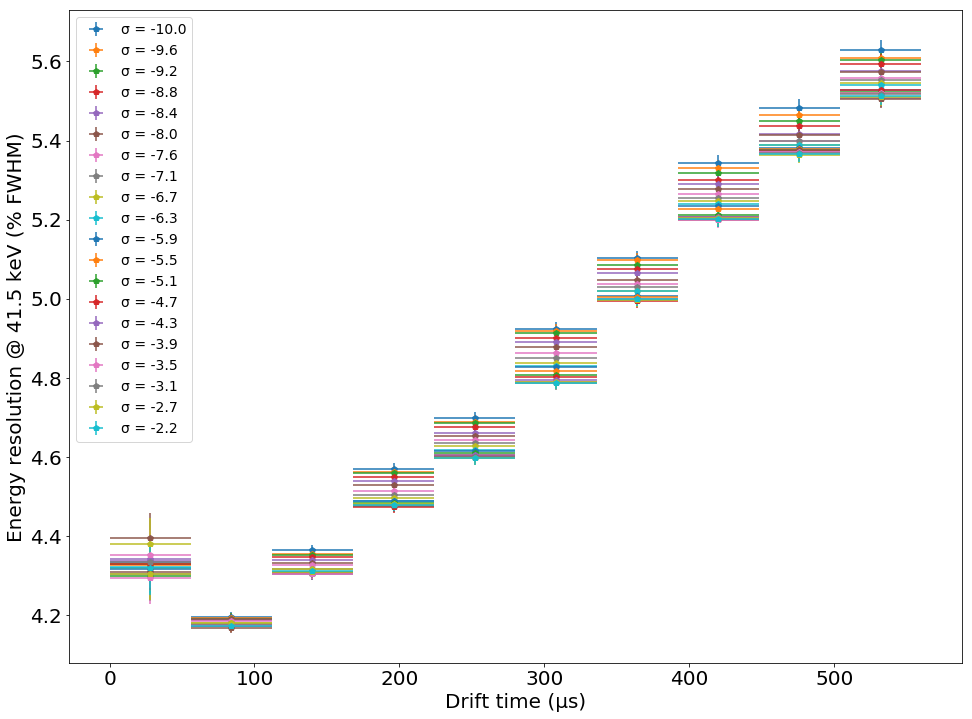

In [34]:
for i in range(nsigmas_lt):
    ok = zok_lt[i]
    plt.errorbar(z_lt[i][ok], zR_lt[i][ok], zRu_lt[i][ok], np.diff(Zcenters)[0]/2,
                 fmt = "p", label = f"σ = {sigmas_geo[i]:.1f}")

plt.legend(fontsize=14)
labels("Drift time (µs)", "Energy resolution @ 41.5 keV (% FWHM)")

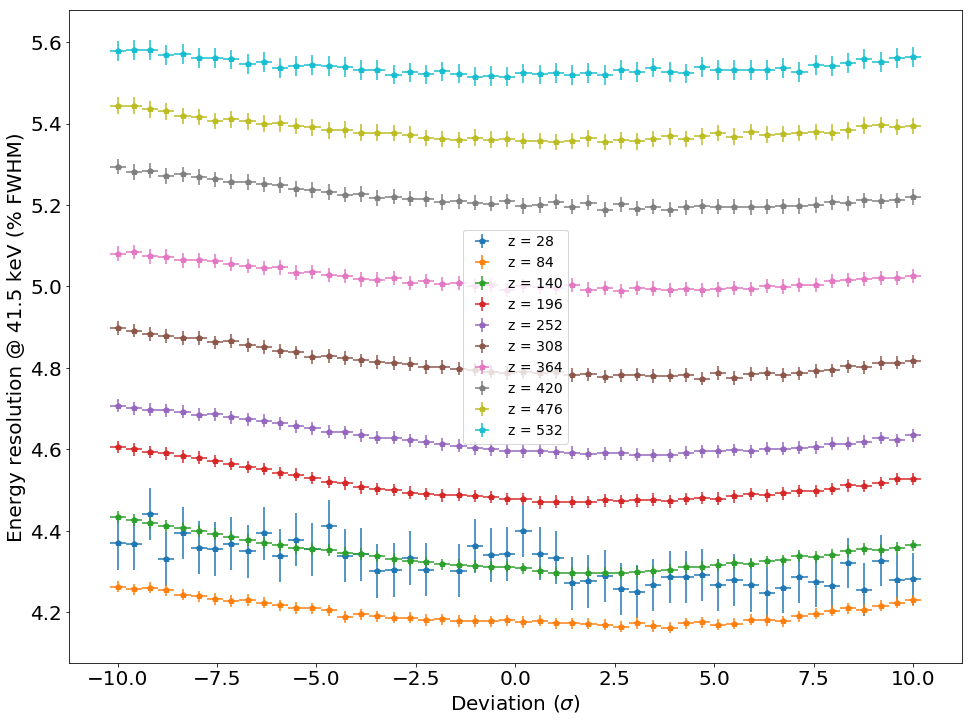

In [37]:
for i in range(Znbins):
    ok = zok_geo[:, i]
    plt.errorbar(sigmas_geo[ok], zR_geo[:, i][ok], zRu_geo[:, i][ok], np.diff(sigmas_geo)[0]/2,
                 fmt = "p", label = f"z = {Zcenters[i]:.0f}")

plt.legend(fontsize=14)
labels("Deviation ($\sigma$)", "Energy resolution @ 41.5 keV (% FWHM)")

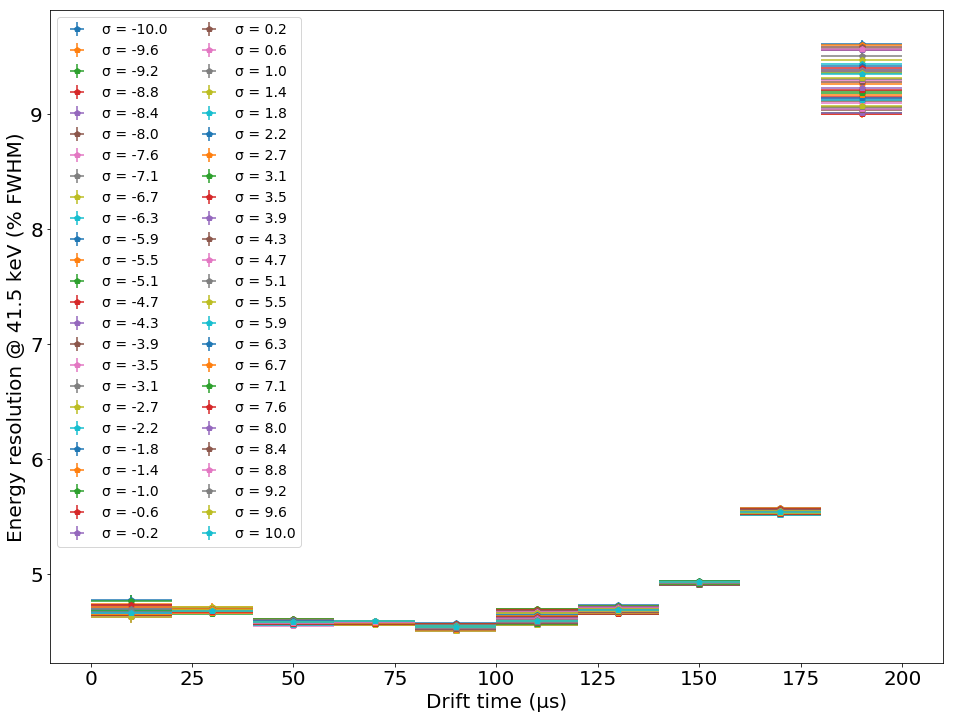

In [40]:
for i in range(nsigmas_geo):
    ok = rok_geo[i]
    plt.errorbar(r_geo[i][ok], rR_geo[i][ok], rRu_geo[i][ok], np.diff(Rcenters)[0]/2,
                 fmt = "p", label = f"σ = {sigmas_geo[i]:.1f}")

plt.legend(fontsize=14, ncol=2)
labels("Drift time (µs)", "Energy resolution @ 41.5 keV (% FWHM)")

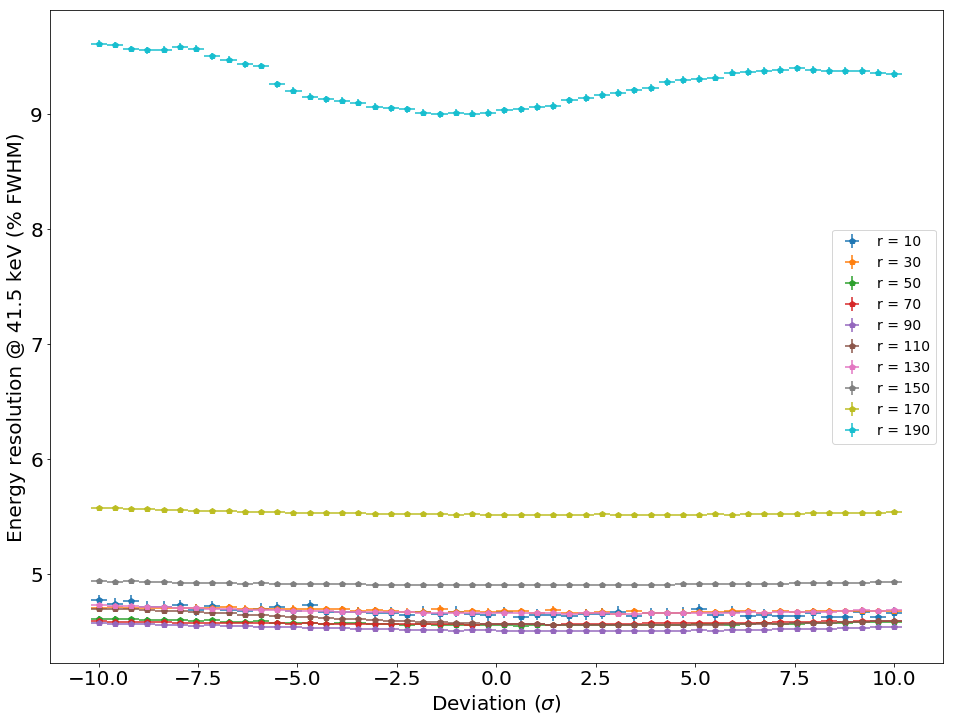

In [39]:
for i in range(Znbins):
    ok = rok_geo[:, i]
    plt.errorbar(sigmas_geo[ok], rR_geo[:, i][ok], rRu_geo[:, i][ok], np.diff(sigmas_geo)[0]/2,
                 fmt = "p", label = f"r = {Rcenters[i]:.0f}")

plt.legend(fontsize=14)
labels("Deviation ($\sigma$)", "Energy resolution @ 41.5 keV (% FWHM)")

Resolution at 41.5 keV: 4.9575 +- 0.0059
Resolution at 2458 keV: 0.64416 +- 0.00076
Chi2                  : 63.8052100879


(0, 33924.940643404138)

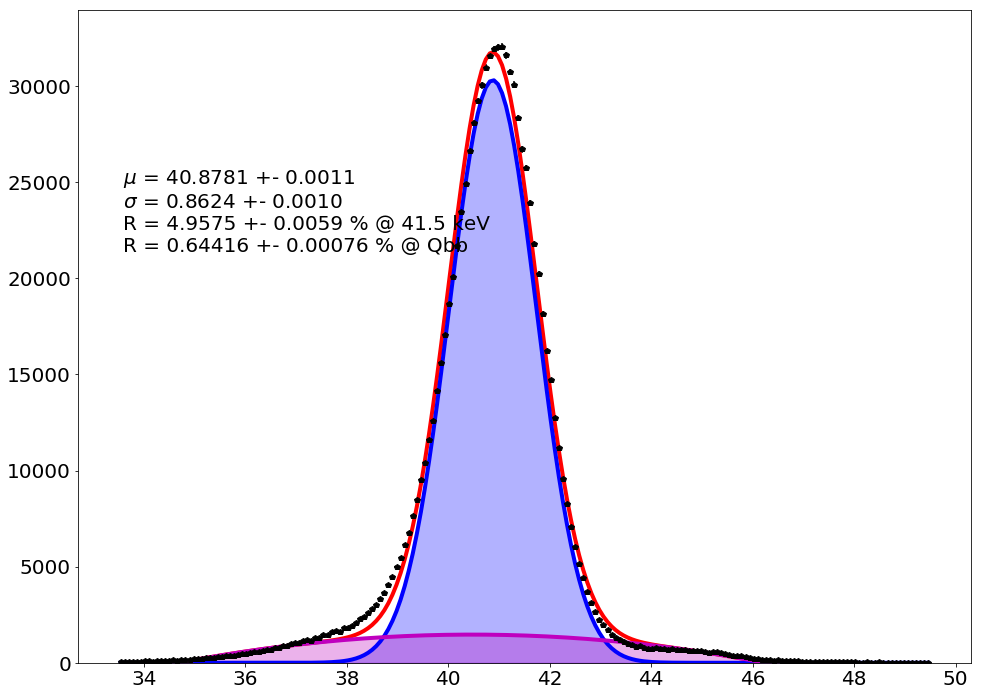

In [17]:
bkg = fitf.polynom
data = datas[-20]
print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)
plt.figure()
x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn   (x)                   , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, bkg       (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, bkg       (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))
plt.ylim(0)